<a href="https://colab.research.google.com/github/tvml/ml2122/blob/master/codici/naivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Naive Bayes text classifier

In [ ]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [15]:
IS_COLAB = ('google.colab' in str(get_ipython()))

In [16]:
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [11]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09',
         '#c79fef', '#80f9ad']

In [12]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2122/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

Legge il dataset

In [17]:
if IS_COLAB:
    data = io.loadmat(get_file('XwindowsDocData.mat',local=0))
else:
    data = io.loadmat(get_file('XwindowsDocData.mat',local=1))

xtrain = data['xtrain']
ytrain = data['ytrain']

ndocs = xtrain.shape[0] 
nterms = xtrain.shape[1]
classes = np.unique(ytrain)
nclasses = classes.shape[0]

In [8]:
xtrain.shape

(900, 600)

Crea un classificatore Naive-Bayes ed effettua il learning sul dataset

In [4]:
clf = MultinomialNB(alpha=1.0e-9)
clf.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=1e-09)

Deriva probabilità a priori delle classi $p(C_i)$

In [5]:
pclass=np.exp(clf.class_log_prior_)

Deriva probabilità a posteriori delle feature (termini) $p(t_j|C_i)$

In [6]:
pf=np.exp(clf.feature_log_prob_)

Deriva probabilità a priori delle feature $p(t_j)=p(t_j|C_1)p(C_1)+p(t_j|C_2)p(C_2)$

In [7]:
pfeature=np.array([pf[0,i]*pclass[0]+pf[1,i]*pclass[1] for i in range(pf.shape[1])])

Plot del modello di linguaggio risultante per le due classi

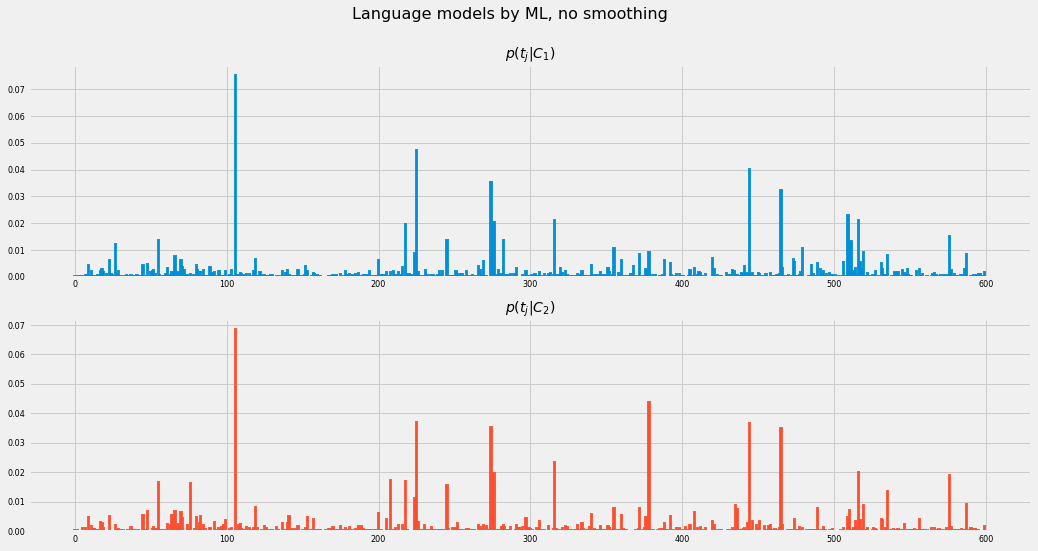

In [8]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), pf[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle('Language models by ML, no smoothing ', fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [16]:
preds = clf.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds)))

Accuracy = 0.9211111


Istanza classificatore Naive-Bayes con Dirichlet smoothing simmetrico, con iperparametro $\alpha$ ed effettua il learning sul dataset

In [17]:
alpha = 100
clf1 = MultinomialNB(alpha)
clf1.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=100, class_prior=None, fit_prior=True)

Deriva probabilità a posteriori delle feature (termini) $p(t_j|C_i)$

In [18]:
pf1=np.exp(clf1.feature_log_prob_)

Plot del modello di linguaggio risultante per le due classi

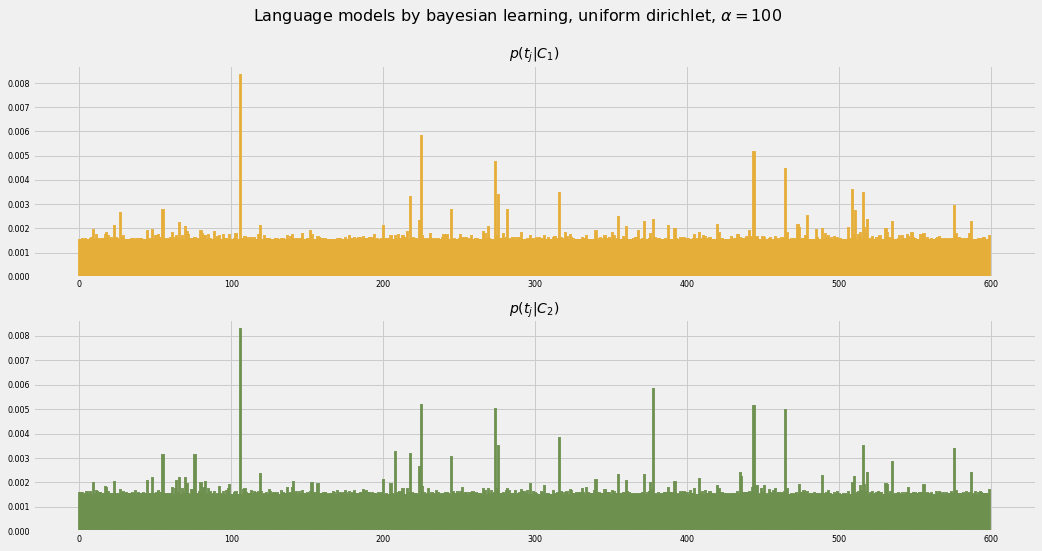

In [19]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf1.feature_count_.shape[1]), pf1[i,:],  facecolor=colors[i+2], alpha=0.9, edgecolor=colors[i+2], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle(r"Language models by bayesian learning, uniform dirichlet, $\alpha= {0:2d}$".format(alpha), fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [20]:
preds1 = clf1.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds1)))

Accuracy = 0.8533333


Definizione della funzione che calcola la mutua informazione di una feature con le due classi

In [20]:
def mutual_information(feature):
    s = 0
    for cl in [0,1]:
        s += pf[cl, feature]*pclass[cl]*np.log2(pf[cl, feature]/pfeature[feature])
    return s

Calcolo del valore della mutua informazione per ogni feature

In [21]:
mi = np.array([mutual_information(f) for f in range(pf.shape[1])])

Ordinamento crescente delle feature rispetto alla mutua informazione

In [22]:
ordered_features = np.argsort(mi)

Plot della mutua informazione delle feature

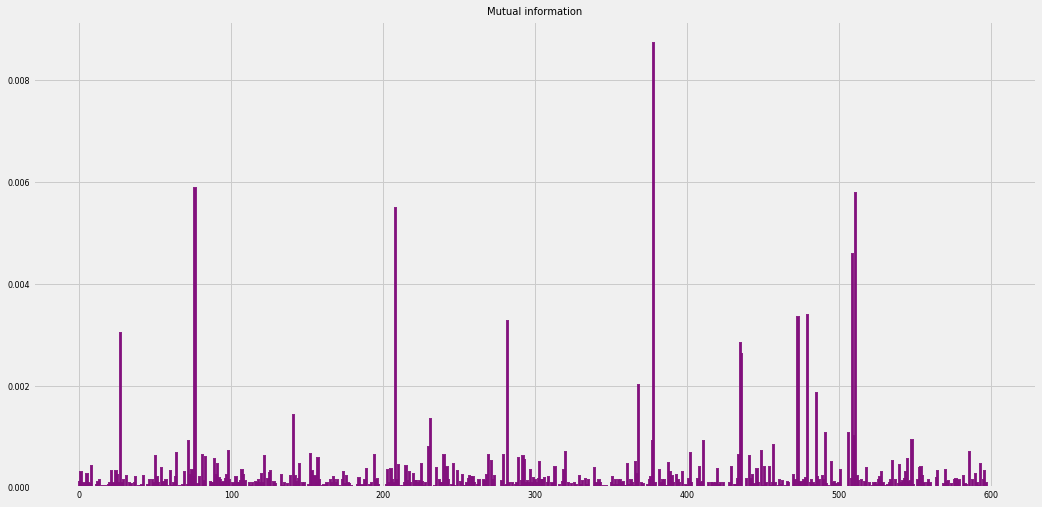

In [23]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(clf1.feature_count_.shape[1]), mi,  facecolor=colors[5], alpha=0.9, edgecolor=colors[5], lw=2)
plt.title(r"Mutual information")
plt.show()

Seleziona le feature più informative e riduci il training set considerando solo quelle

In [24]:
k = 15
x_red = xtrain[:, ordered_features[-k:]]

Plot della mutua informazione delle feature selezionate

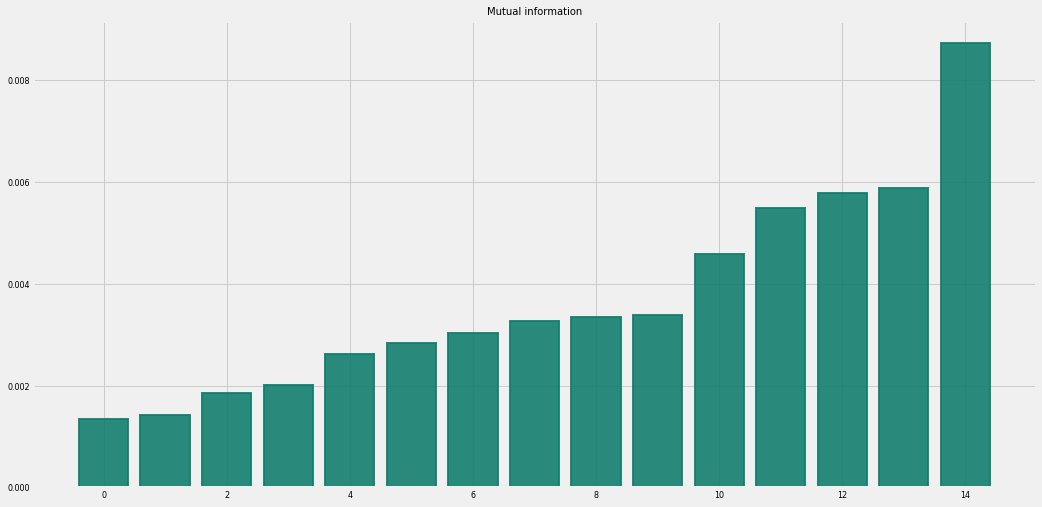

In [25]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(k), mi[ordered_features[-k:]],  facecolor=colors[6], alpha=0.9, edgecolor=colors[6], lw=2)
plt.title(r"Mutual information")
plt.show()

Crea un nuovo classificatore Naive Bayes ed effettua l'apprendimento sul training set ridotto 

In [27]:
clf2 = MultinomialNB(alpha=1.0e-9)
clf2.fit(x_red, ytrain.ravel())

MultinomialNB(alpha=1e-09, class_prior=None, fit_prior=True)

Applicazione del classificatore al training set ridotto e derivazione della accuracy

In [28]:
preds2 = clf2.predict(x_red)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds2)))

Accuracy = 0.8777778
